<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Условный интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нужно обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Предполагается построить модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

Для выполнения проекта не применяется *BERT*.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Импорт библиотеки pandas
import pandas as pd
# Импорт библиотеки numpy
import numpy as np
# Импорт библиотеки matplotlib
import matplotlib.pyplot as plt
# Импорт библиотеки math
import math
# Импорт библиотеки time
import time
# Импорт библиотеки re
import re
# Импорт библиотеки nltk
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Импорт библиотеки sklearn и необходимых компонентов
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score 
from sklearn.pipeline import Pipeline
# Импорт библиотек алгоритмов градиентного бустинга
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
# Удаление ложных предупреждений
pd.options.mode.chained_assignment = None  # default='warn'
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

<font color='DarkBlue'> 
📌 Импортированы все библиотеки, используемые далее в проекте, и скорректированы настройки <br>
</font> 

In [2]:
# Загрузка таблицы в память переменной df типа dataframe
df = pd.read_csv('/datasets/toxic_comments.csv')
# Разделители для удобства отображения информации указаны в виде отдельных пунктов 'print("\033[1m\033[43m {}".format('----- Text -----'),"\033[0m")'
print('\033[1m\033[43m {}'.format('----- Просмотр общей информации о dataframe -----'),'\033[0m')
df.info()
print('\033[1m\033[43m {}'.format('----- Информация о заголовках полей dataframe -----'),'\033[0m')
print(df.columns)
print('\033[1m\033[43m {}'.format('----- Информация о типах полей dataframe -----'),'\033[0m')
print(df.dtypes)
print('\033[1m\033[43m {}'.format('----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа -----'),'\033[0m')
display(df.head())
print('Количество явных дубликатов', df.duplicated().sum())

 ----- Просмотр общей информации о dataframe ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
 ----- Информация о заголовках полей dataframe ----- 
Index(['text', 'toxic'], dtype='object')
 ----- Информация о типах полей dataframe ----- 
text     object
toxic     int64
dtype: object
 ----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа ----- 


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Количество явных дубликатов 0


<font color='DarkBlue'> 
📌 В ходе первичного анализа данных сформированы следующие выводы: <br>
    
1. Отсутствует необходимость в редактировании заголовков, названия представлены в условно общепринятом формате
2. Пропуски в столбцах не обнаружены
3. Отсутствуют явные дубликаты и, соответственно, необходимость удаления повторяющихся объектов
4. Тип данных числовых полей можно преобразовать для уменьшения требуемого объема памяти хранения данных
5. Среди табличных данных возможно появление некорректных значений, рекомендуется детальный анализ по параметрам столбцов и построение гистограммы распределения для целевого признака
</font> 

,text
count,159571
unique,159571
top,Rock'n'Roll \n\nshouldn't this be in their gen...
freq,1


,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
50%,0.000000
max,1.000000


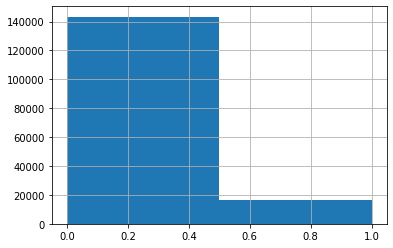

In [3]:
display(df.describe(include=['object']))
display(df.describe(percentiles=[0.5]))
df['toxic'].hist(bins=len(df['toxic'].unique()))
plt.show()

<font color='DarkBlue'> 
📌 Большинство отзывов являются положительными, для реализации корректного процесса обучения далее присутствует необходимость в стратифицированном разделении выборок на обучающую и тестовую <br>      
📌 Также рекомендуется преобразование типов данных, если отсутствует необходимость в осуществлении дальнейших арифметических операций с содержимым полей <br>
</font> 

In [4]:
df[df.select_dtypes(include=['int']).columns] = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df[df.select_dtypes(include=['float']).columns] = df.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  uint8 
dtypes: object(1), uint8(1)
memory usage: 1.4+ MB


<font color='DarkBlue'> 
📌 Необходимо привести записи к общему виду для последующей обработки, исключив лишние символы: все, кроме английских букв и пробелов, и лемматизировав тексты. Для этого требуется создать соответствующие функции <br> 
📌 Сначала нужно выделить корпус, представляющий набор текстов, из исходного датасета и создать класс для лемматизации <br>     
</font> 

In [5]:
corpus = df['text']

In [6]:
# m = Mystem()

In [7]:
# def lemmatize(text):
#     lemm_list = m.lemmatize(text)
#     lemm_text = ''.join(lemm_list)        
#     return lemm_text

In [9]:
lemmatizer = WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
def lemmatize(text):
    lemm_list = []
    tokens = word_tokenize(text)
    for token in tokens:
        lemmetized_word = lemmatizer.lemmatize(token, get_wordnet_pos(token))
        lemm_list.append(lemmetized_word)
    lemm_text = ' '.join(lemm_list) 
    return lemm_text

In [12]:
def clear_text(text):
    new_text = re.sub(r'[^a-zA-Z ]', ' ', text) 
    new_text = new_text.split()   
    new_text = ' '.join(new_text)
    return new_text

<font color='DarkBlue'> 
📌 Можно проверить корректность выполнения объявленных функций на одном из объектов исходного датасета <br>   
</font> 

In [13]:
print('Исходный текст')
print(corpus[0])
print('-----')
print('Очищенный и лемматизированный текст')
print(lemmatize(clear_text(corpus[0])))

Исходный текст
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
-----
Очищенный и лемматизированный текст
Explanation Why the edits make under my username Hardcore Metallica Fan be revert They weren t vandalism just closure on some GAs after I vote at New York Dolls FAC And please don t remove the template from the talk page since I m retire now


<font color='DarkBlue'> 
📌 Преобразование текста выполняется корректно <br> 
📌 Далее необходимо создать новое поле с данными в соответствии с использованием упомянутого выше алгоритма. Функция лемматизации, используемая для общего пула исходных данных, в данном окружении может не исполняться, поэтому предлагается разбить датасет на батчи и выполнять преобразования с ними поочередно. Сначала нужно определить их количество, а также остаток для вычисления количества записей в крайней итерации <br>     
</font> 

In [14]:
df['lemm_text'] = pd.Series(corpus).apply(lambda x: lemmatize(clear_text(x)))

In [15]:
# %%time
# cnt = len(df) // 5000 + 1
# div = len(df) % 5000
# print('Количество батчей:', cnt)
# for batch in range(cnt):
#     start_time = time.time()
#     if batch < cnt - 1:
#         df.loc[(5000 * batch):(5000 * (batch + 1)), 'lemm_text'] = pd.Series(corpus[(5000 * batch):(5000 * (batch + 1))], index=range(5000 * batch,5000 * (batch + 1))).apply(lambda x: lemmatize(clear_text(x)))
#     else:
#         df.loc[(len(df) - div):, 'lemm_text'] = pd.Series(corpus[(len(df) - div):], index=range(len(corpus) - div,len(corpus))).apply(lambda x: lemmatize(clear_text(x)))
#     print('Время прохождения итерации', batch + 1, ':', round((time.time() - start_time) * 1000), 'ms')
# print('Количество пропущенных записей после преобразования:', df['lemm_text'].isna().sum())

<font color='DarkBlue'> 
📌 Можно удостовериться в том, что все записи корректно обработаны <br>     
</font> 

In [16]:
df

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not try to edit war It s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir be my hero Any chance you remember wha...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,And for the second time of ask when your view ...
159567,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That be a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm there no actual article for prosti...
159569,And it looks like it was actually you who put ...,0,And it look like it be actually you who put on...


## Обучение

<font color='DarkBlue'> 
📌 Для более корректной классификации необходимо загрузить список стоп-слов, не несущих соответствующей смысловой нагрузки и, соответственно, не участвующих в определении тональности текста <br>     
</font> 

In [17]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<font color='DarkBlue'> 
📌 Далее требуется разбить выборки на обучающую и тестовую в соотношении 3:1 <br>     
</font> 

In [18]:
df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['toxic'], random_state=12345)

In [19]:
# %%time
# cnt = len(df_train) // 5000 + 1
# div = len(df_train) % 5000
# print('Количество батчей:', cnt)
# corpus_train = pd.Series(dtype='object', index=range(len(df_train)))
# for batch in range(cnt):
#     start_time = time.time()
#     if batch < cnt - 1:
#         corpus_train.loc[(5000 * batch):(5000 * (batch + 1))] = pd.Series(df_train[(5000 * batch):(5000 * (batch + 1))]['lemm_text'].values.astype('U'), index=range(5000 * batch,5000 * (batch + 1)))
#     else:
#         corpus_train.loc[(len(df_train) - div):] = pd.Series(df_train[len(df_train) - div:]['lemm_text'].values.astype('U'), index=range(len(df_train) - div,len(df_train)))
#     print('Время прохождения итерации', batch + 1, ':', round((time.time() - start_time) * 1000), 'ms')
# corpus_test = df_test['lemm_text'].values.astype('U')

In [20]:
corpus_train, corpus_test = [table['lemm_text'] for table in [df_train, df_test]]

In [21]:
# count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
# tf_idf_train = count_tf_idf.fit_transform(corpus_train)
# tf_idf_test = count_tf_idf.transform(corpus_test)

<font color='DarkBlue'> 
📌 Для удобства формирования дальнейших расчетов можно создать функции обучения моделей и осуществления предсказаний с определением времени и таблицу для фиксации результатов предсказаний <br>  
</font>

In [22]:
def fit(model, cv):     
    if cv == True:
        grid.fit(corpus_train, df_train['toxic'])
        print('Лучшая модель:', grid.best_estimator_)
        print('Параметры лучшей модели:', grid.best_params_)  
        print('Лучшая усредненная по кросс-валидации метрика F1 модели:', grid.best_score_)
        model = grid.best_estimator_
    start_time = time.time()
    model.fit(corpus_train, df_train['toxic'])
    t_train = round((time.time() - start_time) * 1000)
    print('Время обучения:', t_train, 'ms')
    return model, t_train

In [23]:
def predict(model):    
    start_time = time.time()
    df_predicted_test = model.predict(corpus_test)
    t_predict = round((time.time() - start_time) * 1000)   
    print('Время предсказания:', t_predict, 'ms')
    df_predicted_train = model.predict(corpus_train)    
    accuracy_train = model.score(corpus_train, df_train['toxic'])
    accuracy_test = model.score(corpus_test, df_test['toxic'])
    f1_train = f1_score(df_train['toxic'], df_predicted_train)
    f1_test = f1_score(df_test['toxic'], df_predicted_test)
    recall_test = recall_score(df_test['toxic'], df_predicted_test)
    precision_test = precision_score(df_test['toxic'], df_predicted_test, zero_division=0)
    df_probabilities_valid = model.predict_proba(corpus_test)
    df_probabilities_one_valid = df_probabilities_valid[:, 1]
    roc_test = roc_auc_score(df_test['toxic'], df_probabilities_one_valid)
    print('Accuracy модели на обучающей выборке:', accuracy_train)
    print('Accuracy модели на тестовой выборке:', accuracy_test)
    print('F1 модели на обучающей выборке:', f1_train)
    print('F1 модели на тестовой выборке:', f1_test)
    print('Recall:', recall_test)
    print('Precision:', precision_test)
    print('Площадь под ROC-кривой', roc_test)
    print('Матрица ошибок')
    print(confusion_matrix(df_test['toxic'], df_predicted_test))    
    return accuracy_train, accuracy_test, f1_train, f1_test, recall_test, precision_test, roc_test, t_predict

In [24]:
table = pd.DataFrame(columns = ['name', 'accuracy_train', 'accuracy_test', 'f1_train', 'f1_test', 'recall_test', 'precision_test', 'roc_test', 't_train', 't_predict'])

<font color='DarkBlue'> 
📌 Модель необходимо обозначить в качестве Pipeline для осуществления векторизации обучающей выборки во время подбора параметров. Отсутствует нгеобходимость в дальнейших преобразованиях данных для обучения моделей алгоритмами классификации <br> 
📌 Сначала можно обучить модель с использованием алгоритма DummyClassifier для сравнения с далее представленными методами обучениями и вывления их адекватности <br> 
</font> 

In [25]:
%%time
model = Pipeline([('vect', CountVectorizer(stop_words=stopwords)), ('tfidf', TfidfTransformer()), ('clf', DummyClassifier(random_state=12345))])
model, t_train = fit(model, False)

Время обучения: 4519 ms
CPU times: user 4.41 s, sys: 96.1 ms, total: 4.5 s
Wall time: 4.52 s


In [26]:
accuracy_train, accuracy_test, f1_train, f1_test, recall_test, precision_test, roc_test, t_predict = predict(model)
table = table.append({'name': 'DummyClassifier', 'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'f1_train': f1_train, 'f1_test': f1_test, 'recall_test': recall_test, 'precision_test': precision_test, 'roc_test': roc_test, 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

Время предсказания: 1397 ms
Accuracy модели на обучающей выборке: 0.8983188221728304
Accuracy модели на тестовой выборке: 0.8983280274734916
F1 модели на обучающей выборке: 0.0
F1 модели на тестовой выборке: 0.0
Recall: 0.0
Precision: 0.0
Площадь под ROC-кривой 0.5
Матрица ошибок
[[35837     0]
 [ 4056     0]]


<font color='DarkBlue'> 
📌 На основе отображенной информации можно обозначить следующие выводы:  
    
- время обучения и предсказания модели достаточно малое, следует учесть, что не осуществлялся перебор по гиперпараметрам
- точность достаточно высокая вследствие достаточного дисбаланса классов
- Площадь под ROC-кривой 0.5 в соответствии с концепцией DummyClassifier
    
📌 Теперь требуется обучить модель с использованием алгоритма LogisticRegression и подобрать наилучшие гиперпараметры в соответствии с метрикой F1. Можно установить параметр регуляризации 5, предполагается, что результаты будут лучше, но модель будет показывать некое переобучение, и чем больше соответствующий параметр в определенных пределах, тем лучше качество модели. В дальнейшем учитывается, что перебор гиперпараметров с использованием кросс-валидации самостоятельно разбивает модель на обучающие и валидационные выборки, следовательно, необходимость в ручной операции их разделения отпадает <br> 
</font> 

In [27]:
%%time
model = Pipeline([('vect', CountVectorizer(stop_words=stopwords)), ('tfidf', TfidfTransformer()), ('clf', LogisticRegression(n_jobs=-1, random_state=12345, max_iter=1000, C=5))])
parameters = {'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 
grid = GridSearchCV(estimator=model, param_grid=parameters, scoring='f1', n_jobs=-1, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=12345))
model, t_train = fit(model, True)

Лучшая модель: Pipeline(steps=[('vect',
                 CountVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=5, max_iter=1000, n_jobs=-1,
                                    random_state=12345, solver='liblinear'))])
Параметры лучшей модели: {'clf__solver': 'liblinear'}
Лучшая метрика F1: 0.7580073155684972
Время обучения: 18891 ms
CPU times: user

In [28]:
accuracy_train, accuracy_test, f1_train, f1_test, recall_test, precision_test, roc_test, t_predict = predict(model)
table = table.append({'name': 'LogisticRegression', 'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'f1_train': f1_train, 'f1_test': f1_test, 'recall_test': recall_test, 'precision_test': precision_test, 'roc_test': roc_test, 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

Время предсказания: 1562 ms
Accuracy модели на обучающей выборке: 0.9744648139173449
Accuracy модели на тестовой выборке: 0.9595919083548492
F1 модели на обучающей выборке: 0.8619942196531792
F1 модели на тестовой выборке: 0.7727016356457981
Recall: 0.6755424063116371
Precision: 0.9025032938076416
Площадь под ROC-кривой 0.9722239960419077
Матрица ошибок
[[35541   296]
 [ 1316  2740]]


<font color='DarkBlue'> 
📌 На основе указанной информации можно обозначить следующие выводы:  
    
- время обучения относительно небольшое, но выше, чем у примитивной модели, также уже осуществляется подбор наилучших гиперпараметров для обучения
- качество модели хорошее, но следует учесть, что метрики усреднены после выполнения перекрестного обучения
- модель немного переобучена, так как исследуемые по предсказаниям метрики на обучающей выборке заметно больше, чем на тестовой
    
📌 Для обучения модели с использованием алгоритма RandomForestClassifier необходимо использовать существующие выборки <br> 
</font> 

In [29]:
%%time
model = Pipeline([('vect', CountVectorizer(stop_words=stopwords)), ('tfidf', TfidfTransformer()), ('clf', RandomForestClassifier(n_jobs=-1, random_state=12345))])
parameters = {'clf__n_estimators': range (11, 31, 10), 'clf__max_depth': range (3, 6)}
grid = GridSearchCV(estimator=model, param_grid=parameters, scoring='f1', n_jobs=-1, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=12345))
model, t_train = fit(model, True)

Лучшая модель: Pipeline(steps=[('vect',
                 CountVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(max_depth=3, n_estimators=11, n_jobs=-1,
                                        random_state=12345))])
Параметры лучшей модели: {'clf__max_depth': 3, 'clf__n_estimators': 11}
Лучшая метрика F1: 0.0
Время обучения: 4991 ms
CPU times: user

In [30]:
accuracy_train, accuracy_test, f1_train, f1_test, recall_test, precision_test, roc_test, t_predict = predict(model)
table = table.append({'name': 'RandomForestClassifier', 'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'f1_train': f1_train, 'f1_test': f1_test, 'recall_test': recall_test, 'precision_test': precision_test, 'roc_test': roc_test, 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

Время предсказания: 1491 ms
Accuracy модели на обучающей выборке: 0.8983188221728304
Accuracy модели на тестовой выборке: 0.8983280274734916
F1 модели на обучающей выборке: 0.0
F1 модели на тестовой выборке: 0.0
Recall: 0.0
Precision: 0.0
Площадь под ROC-кривой 0.6530431363869248
Матрица ошибок
[[35837     0]
 [ 4056     0]]


<font color='DarkBlue'> 
📌 На основе указанной информации можно обозначить следующие выводы:  
    
- время обучения малое, но выше, сопоставимо с таковым у простейшего алгоритма
- качество модели неудовлетворительное, такое же, как и при использовании DummyClassifier
- модель не переобучена, имеет плохие показатели, возможно необходимо изменение и использование других гиперпараметров, в данном случае модель скорее 'перестраховывается', полагая, что класс единиц является достаточно редким и непредсказываемым
    
📌 Далее можно проверить алгоритм LGBMClassifier, этот алгоритм построен на функционале предыдущего <br> 
</font> 

In [31]:
%%time
model = Pipeline([('vect', CountVectorizer(stop_words=stopwords)), ('tfidf', TfidfTransformer()), ('clf', LGBMClassifier(n_jobs=-1, random_state=12345))])
parameters = {'clf__n_estimators': range (11, 31, 10), 'clf__max_depth': range (3, 6)}
grid = GridSearchCV(estimator=model, param_grid=parameters, scoring='f1', n_jobs=-1, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=12345))
model, t_train = fit(model, True)
# 'num_leaves': range (31, 51, 10)
# 'boosting_type': ['gbdt', 'rf', 'dart', 'goss']
# 'learning_rate': [0.1]

Лучшая модель: Pipeline(steps=[('vect',
                 CountVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LGBMClassifier(max_depth=5, n_estimators=21,
                                random_state=12345))])
Параметры лучшей модели: {'clf__max_depth': 5, 'clf__n_estimators': 21}
Лучшая метрика F1: 0.46806433230929495
Время обучения: 58433 ms
CPU times: user 11min 51s

In [32]:
accuracy_train, accuracy_test, f1_train, f1_test, recall_test, precision_test, roc_test, t_predict = predict(model)
table = table.append({'name': 'LGBMClassifier', 'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'f1_train': f1_train, 'f1_test': f1_test, 'recall_test': recall_test, 'precision_test': precision_test, 'roc_test': roc_test, 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

Время предсказания: 1951 ms
Accuracy модели на обучающей выборке: 0.9300874011932018
Accuracy модели на тестовой выборке: 0.9293861078384679
F1 модели на обучающей выборке: 0.4818874233698681
F1 модели на тестовой выборке: 0.4774624373956594
Recall: 0.3173076923076923
Precision: 0.9640449438202248
Площадь под ROC-кривой 0.8772351331987
Матрица ошибок
[[35789    48]
 [ 2769  1287]]


<font color='DarkBlue'> 
📌 На основе указанной информации можно обозначить следующие выводы:  
    
- время обучения большое, выше, чем у предыдущих моделей, возможно использовались более значимые наборы гиперпараметров и по умолчанию высокий фактор скорости обучения
- качество модели лучше, чем у предыдущего результата, но не является удовлетворительным для текущей задачи
- модель не переобучена, метрики качества по предсказаниям на обучающей выборке аналогичны таковым на валидационной
    
📌 Также можно обучить модель с использованием алгоритма CatBoostClassifier <br> 
</font> 

In [33]:
%%time
model = Pipeline([('vect', CountVectorizer(stop_words=stopwords)), ('tfidf', TfidfTransformer()), ('clf', CatBoostClassifier(loss_function='Logloss', random_state=12345, learning_rate=0.5, verbose=0))])
parameters = {'clf__iterations': range (11, 31, 10), 'clf__depth': range (3, 6)}
grid = GridSearchCV(estimator=model, param_grid=parameters, scoring='f1', n_jobs=-1, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=12345))
model, t_train = fit(model, True)
# 'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
# 'bootstrap_type': ['Bayesian', 'MVS', 'Poisson', 'No']
# 'boosting_type': ['Ordered', 'Plain']
# 'learning_rate': [0.1]

Лучшая модель: Pipeline(steps=[('vect',
                 CountVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7fd00e544dc0>)])
Параметры лучшей модели: {'clf__depth': 5, 'clf__iterations': 21}
Лучшая метрика F1: 0.6653641184687121
Время обучения: 66754 ms
CPU times: user 12min 22s, sys: 37.6 s, total: 13min
Wall time: 13min

In [34]:
accuracy_train, accuracy_test, f1_train, f1_test, recall_test, precision_test, roc_test, t_predict = predict(model)
table = table.append({'name': 'CatBoostClassifier', 'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'f1_train': f1_train, 'f1_test': f1_test, 'recall_test': recall_test, 'precision_test': precision_test, 'roc_test': roc_test, 't_train': t_train, 't_predict': t_predict}, ignore_index=True)

Время предсказания: 1782 ms
Accuracy модели на обучающей выборке: 0.9459299119303465
Accuracy модели на тестовой выборке: 0.9447020780588073
F1 модели на обучающей выборке: 0.65774580843074
F1 модели на тестовой выборке: 0.6482780612244898
Recall: 0.501232741617357
Precision: 0.9174187725631769
Площадь под ROC-кривой 0.9024304393457141
Матрица ошибок
[[35654   183]
 [ 2023  2033]]


<font color='DarkBlue'> 
📌 На основе представленной информации можно обозначить следующие выводы:  
    
- время обучения модели на используемых данных больше, чем у остальных, в соответствии с концепцией алгоритма
- качество модели и метрики лучше, как у модели, обученной предыдущим алгоритмом, удовлетворительное
- модель не переобучена согласно указанным метрикам для обучающей и валидационной выборок

📌 Теперь по сводной таблице можно проанализировать результаты обучения модели разными алгоритмами <br>
</font> 

In [35]:
table

,name,accuracy_train,accuracy_test,f1_train,f1_test,recall_test,precision_test,roc_test,t_train,t_predict
0,DummyClassifier,0.898319,0.898328,0.000000,0.000000,0.000000,0.000000,0.500000,4519,1397
1,LogisticRegression,0.974465,0.959592,0.861994,0.772702,0.675542,0.902503,0.972224,18891,1562
2,RandomForestClassifier,0.898319,0.898328,0.000000,0.000000,0.000000,0.000000,0.653043,4991,1491
3,LGBMClassifier,0.930087,0.929386,0.481887,0.477462,0.317308,0.964045,0.877235,58433,1951
4,CatBoostClassifier,0.945930,0.944702,0.657746,0.648278,0.501233,0.917419,0.902430,66754,1782


<font color='DarkBlue'>   
📌 Все обученные модели являются адекватными, площадь под ROC кривой больше 0.5, но алгоритм LogisticRegression показывает заметно лучшие результаты обучения согласно всем представленным метрикам, в том числе меньшее время обучения модели, что значительно облегчает также реализацию процесса ее подбора. Его использование в текущей задаче в соответствии с предпочтительными гиперпараметрами является рекомендуемым  <br> 
📌 Время предсказания всех одинаково малое, чем определяется достаточное удобство пользования представленными обученными моделями, основная разница наблюдается в наиболее приоритетном критерии - качестве обучения <br>
📌 В целом для подобной задачи обучающие алгоритмы методом построения деревьев даже при более подробном рассмотрении показывают худшие результаты, чем выбранный, наилучшим из них является CatBoostClassifier, но время обучения с использованием алгоритмов градиентного бустинга неприемлимо велико, что может являться критичным фактором для ввода в production <br>    
📌 При выборе определенного алгоритма необходимо будет избавиться от фактора переобучения и обратить внимание на более детальный перебор гиперпараметров <br>
</font>

## Выводы

<font color='DarkBlue'>      
📌 На основании произведенных исследований можно сформировать следующие выводы:
    
- предоставленные данные умеренного качества, отсутствуют дубликаты, пропуски и аномалии, но текстовая информация содержит лишний контент вида неиспользуемых в процессе обучения модели символов, для более удобного использования необходимо преобразование типов данных в форматы, занимающие меньший объем памяти
- определено, что наилучшим алгоритмом обучения модели для классификации комментариев по тональности в соответствии на исходных данных будет являться LogisticRegression в соответствии с указанными выше обоснованиями после представленных таблиц
- представлен алгоритм подготовки данных (лемматизация, регуляризация, векторизация) для модели и спрогнозирована тональность для объектов тестовой выборки
- значение ключевой метрики F1 согласно анализу предсказаний определения тональности комментариев на тестовой выборке разработанной модели, выбранной для финального представления, больше 0.75
</font>